In [1]:
import pandas as pd
import numpy as np
import pickle
from scipy.stats import randint
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV

In [2]:
dataset=pd.read_csv('website_classification.csv')
dataset.shape

(1408, 4)

In [28]:
dataset.head(10)

,Unnamed: 0,website_url,cleaned_website_text,Category
0,0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel
5,5,https://book.priceline.com/?refid=8431&refclic...,hotel reservations bundle save book flight sal...,Travel
6,6,https://www.trip.com/index?locale=en_us&allian...,official travel deals promotion choose million...,Travel
7,7,https://www.orbitz.com/,bot create free account create free account si...,Travel
8,8,https://www.travelocity.com/,bot create free account create free account si...,Travel
9,9,https://www.hotwire.com/,cheap hotels cars flights minute travel deals ...,Travel


In [4]:
df = dataset[['website_url','cleaned_website_text','Category']].copy()
df.head()

,website_url,cleaned_website_text,Category
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel


In [5]:
pd.DataFrame(df.Category.unique()).values

array([['Travel'],
       ['Social Networking and Messaging'],
       ['News'],
       ['Streaming Services'],
       ['Sports'],
       ['Photography'],
       ['Law and Government'],
       ['Health and Fitness'],
       ['Games'],
       ['E-Commerce'],
       ['Forums'],
       ['Food'],
       ['Education'],
       ['Computers and Technology'],
       ['Business/Corporate'],
       ['Adult']], dtype=object)

Now we need to represent each category as a number, so as our predictive model can better understand the different categories.

In [6]:
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates()

category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

df.head()

,website_url,cleaned_website_text,Category,category_id
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel,0
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel,0
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel,0
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel,0
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel,0


In [7]:
category_id_df

,Category,category_id
0,Travel,0
36,Social Networking and Messaging,1
43,News,2
107,Streaming Services,3
213,Sports,4
398,Photography,5
586,Law and Government,6
670,Health and Fitness,7
768,Games,8
810,E-Commerce,9


In [8]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

features = tfidf.fit_transform(df.cleaned_website_text).toarray()

labels = df.category_id

print("Each of the %d text is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 1408 text is represented by 18865 features (TF-IDF score of unigrams and bigrams)


Spliting the data into train and test sets
The original data was divided into features (X) and target (y), which were then splitted into train (75%) and test (25%) sets. Thus, the algorithms would be trained on one set of data and tested out on a completely different set of data (not seen before by the algorithm).

In [9]:
X = df['cleaned_website_text'] 
y = df['Category'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 42)

In [10]:
y_train.value_counts()

Travel                             86
Business/Corporate                 84
Streaming Services                 80
Health and Fitness                 78
Sports                             75
Education                          75
News                               74
Computers and Technology           74
E-Commerce                         73
Games                              72
Food                               71
Photography                        69
Social Networking and Messaging    62
Law and Government                 58
Forums                             14
Adult                              11
Name: Category, dtype: int64

In [11]:
y_test.value_counts()

Education                          39
E-Commerce                         29
Sports                             29
Games                              26
Law and Government                 26
Streaming Services                 25
Business/Corporate                 25
Photography                        24
News                               22
Social Networking and Messaging    21
Travel                             21
Food                               21
Computers and Technology           19
Health and Fitness                 18
Adult                               5
Forums                              2
Name: Category, dtype: int64

In [12]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    LinearSVC(random_state=42),
    MultinomialNB(),
    GaussianNB()
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.755319
1,RandomForestClassifier,1,0.755319
2,RandomForestClassifier,2,0.705674
3,RandomForestClassifier,3,0.740214
4,RandomForestClassifier,4,0.701068
5,LinearSVC,0,0.858156
6,LinearSVC,1,0.932624
7,LinearSVC,2,0.939716
8,LinearSVC,3,0.903915
9,LinearSVC,4,0.879004


In [13]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
GaussianNB,0.728651,0.055462
LinearSVC,0.902683,0.034687
MultinomialNB,0.852979,0.034688
RandomForestClassifier,0.731519,0.026475


In [14]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df.index, test_size=0.25, 
                                                               random_state=42)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
calibrated_svc = CalibratedClassifierCV(estimator=model,
                                        cv="prefit")

calibrated_svc.fit(X_train,y_train)
predicted = calibrated_svc.predict(X_test)
print(metrics.accuracy_score(y_test, predicted))

0.9147727272727273


In [15]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test,predicted,labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],target_names= df['Category'].unique()))

				CLASSIFICATIION METRICS

                                 precision    recall  f1-score   support

                         Travel       0.91      1.00      0.95        21
Social Networking and Messaging       1.00      0.76      0.86        21
                           News       0.95      0.95      0.95        22
             Streaming Services       0.89      1.00      0.94        25
                         Sports       0.97      0.97      0.97        29
                    Photography       0.85      0.96      0.90        24
             Law and Government       1.00      0.92      0.96        26
             Health and Fitness       0.95      1.00      0.97        18
                          Games       0.96      0.92      0.94        26
                     E-Commerce       0.93      0.93      0.93        29
                         Forums       0.00      0.00      0.00         2
                           Food       0.95      0.86      0.90        21
                     

/Users/sebastianandersonguerrero/proyecto_final_Full_Stack/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sebastianandersonguerrero/proyecto_final_Full_Stack/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sebastianandersonguerrero/proyecto_final_Full_Stack/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

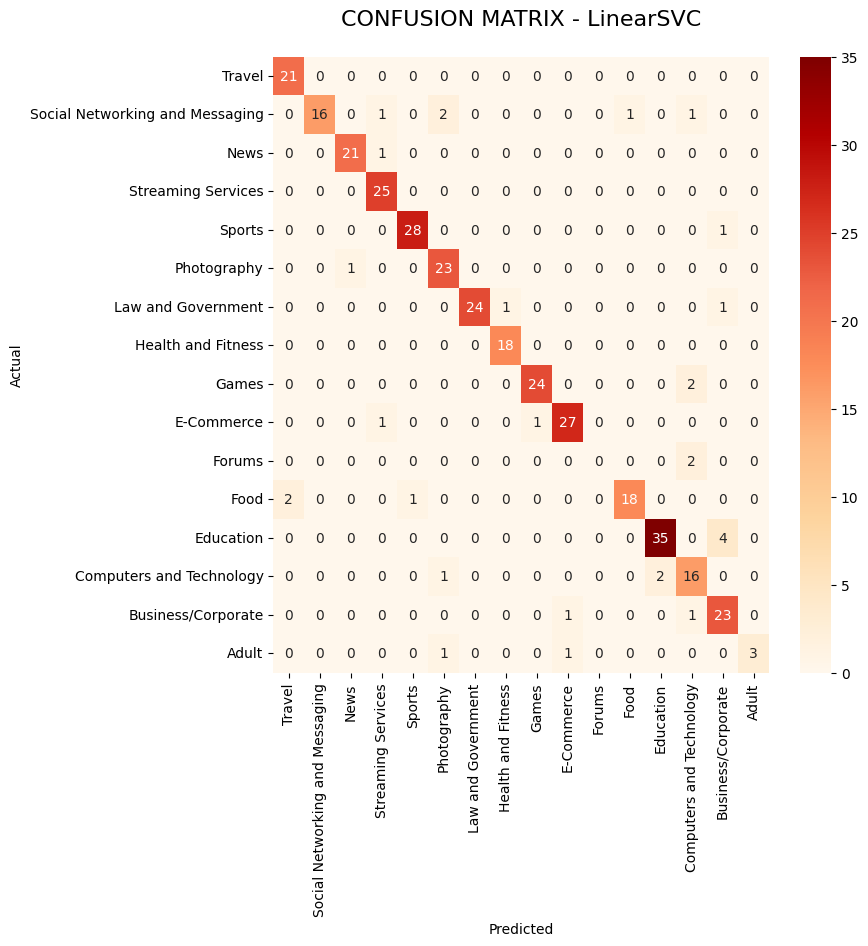

In [16]:
conf_mat = confusion_matrix(y_test, predicted,labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="OrRd", fmt='d',
            xticklabels=category_id_df.Category.values, 
            yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [17]:
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >0:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual],id_to_category[predicted],
                                                                   conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Category', 
                                                                'cleaned_website_text']])

'Food' predicted as 'Travel' : 2 examples.


,Category,cleaned_website_text
945,Food,free table reservation discount offer delhi di...
946,Food,good restaurant mumbai book table online upto ...


'Photography' predicted as 'News' : 1 examples.


,Category,cleaned_website_text
558,Photography,welcome nedu wealth trend blog neduwealth news...


'Social Networking and Messaging' predicted as 'Streaming Services' : 1 examples.


,Category,cleaned_website_text
342,Social Networking and Messaging,facebook इन अप facebook वर इन आपण ओळखत faceboo...


'News' predicted as 'Streaming Services' : 1 examples.


,Category,cleaned_website_text


'E-Commerce' predicted as 'Streaming Services' : 1 examples.


,Category,cleaned_website_text
1093,E-Commerce,amazon fresh skip main content hello select ad...


'Food' predicted as 'Sports' : 1 examples.


,Category,cleaned_website_text
941,Food,tío luchín cocina en vivo cocina en vivo prepa...


'Social Networking and Messaging' predicted as 'Photography' : 2 examples.


,Category,cleaned_website_text
346,Social Networking and Messaging,instagram create account log instagram simple ...


'Computers and Technology' predicted as 'Photography' : 1 examples.


,Category,cleaned_website_text


'Adult' predicted as 'Photography' : 1 examples.


,Category,cleaned_website_text


'Law and Government' predicted as 'Health and Fitness' : 1 examples.


,Category,cleaned_website_text


'E-Commerce' predicted as 'Games' : 1 examples.


,Category,cleaned_website_text
810,E-Commerce,port macquarie hastings bridge club welcome we...


'Business/Corporate' predicted as 'E-Commerce' : 1 examples.


,Category,cleaned_website_text
1389,Business/Corporate,home page pet crafts exquisitely piece handcut...


'Adult' predicted as 'E-Commerce' : 1 examples.


,Category,cleaned_website_text
1400,Adult,zen cart art e commerce sex toy accessories fe...


'Social Networking and Messaging' predicted as 'Food' : 1 examples.


,Category,cleaned_website_text
350,Social Networking and Messaging,pinterest discover recipe home idea style insp...


'Computers and Technology' predicted as 'Education' : 2 examples.


,Category,cleaned_website_text
1192,Computers and Technology,neural network wikipedia neural network conten...
1252,Computers and Technology,quirksmode javascript javascript welcome javas...


'Social Networking and Messaging' predicted as 'Computers and Technology' : 1 examples.


,Category,cleaned_website_text
394,Social Networking and Messaging,xanga xanga xanga xanga xanga news learn theme...


'Games' predicted as 'Computers and Technology' : 2 examples.


,Category,cleaned_website_text
852,Games,clash arm welcome new clash arm web site find ...
823,Games,nylatenite gamer paradise page use frame brows...


'Forums' predicted as 'Computers and Technology' : 2 examples.


,Category,cleaned_website_text
869,Forums,stack overflow developer learn share build car...
875,Forums,ars technica openforum index page hardware twe...


'Business/Corporate' predicted as 'Computers and Technology' : 1 examples.


,Category,cleaned_website_text
1364,Business/Corporate,freelancer freelance jobs freelance projects f...


'Sports' predicted as 'Business/Corporate' : 1 examples.


,Category,cleaned_website_text
261,Sports,sport job sport news sport feature sports mana...


'Law and Government' predicted as 'Business/Corporate' : 1 examples.


,Category,cleaned_website_text
669,Law and Government,british army homepage british army british arm...


'Education' predicted as 'Business/Corporate' : 4 examples.


,Category,cleaned_website_text
998,Education,aes electrophoresis society promote scientific...
1006,Education,home chemistry chemistry integrated independen...
993,Education,california bar exam prep attorneys reviews exe...
977,Education,collegenet serve high ed admissions scheduling...


In [18]:
model.fit(features, labels)

LinearSVC()

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, df['category_id'], 
                                                    test_size=0.25,
                                                    random_state = 42)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

m = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)
m1=CalibratedClassifierCV(estimator=m,
                                        cv="prefit").fit(tfidf_vectorizer_vectors, y_train)


In [20]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 3.5 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [21]:
!pip3 install BeautifulSoup4
!pip3 install spacy

In [22]:
from bs4 import BeautifulSoup
import bs4 as bs4
from urllib.parse import urlparse
import requests
from collections import Counter
import pandas as pd
import os

class ScrapTool:
    def visit_url(self, website_url):
        '''
        Visit URL. Download the Content. Initialize the beautifulsoup object. Call parsing methods. Return Series object.
        '''
        #headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.71 Safari/537.36'}
        content = requests.get(website_url,timeout=60).content
        
        #lxml is apparently faster than other settings.
        soup = BeautifulSoup(content, "lxml")
        result = {
            "website_url": website_url,
            "website_name": self.get_website_name(website_url),
            "website_text": self.get_html_title_tag(soup)+self.get_html_meta_tags(soup)+self.get_html_heading_tags(soup)+
                                                               self.get_text_content(soup)
        }
        
        #Convert to Series object and return
        return pd.Series(result)
    
    def get_website_name(self,website_url):
        '''
        Example: returns "google" from "www.google.com"
        '''
        return "".join(urlparse(website_url).netloc.split(".")[-2])
    
    def get_html_title_tag(self,soup):
        '''Return the text content of <title> tag from a webpage'''
        return '. '.join(soup.title.contents)
    
    def get_html_meta_tags(self,soup):
        '''Returns the text content of <meta> tags related to keywords and description from a webpage'''
        tags = soup.find_all(lambda tag: (tag.name=="meta") & (tag.has_attr('name') & (tag.has_attr('content'))))
        content = [str(tag["content"]) for tag in tags if tag["name"] in ['keywords','description']]
        return ' '.join(content)
    
    def get_html_heading_tags(self,soup):
        '''returns the text content of heading tags. The assumption is that headings might contain relatively important text.'''
        tags = soup.find_all(["h1","h2","h3","h4","h5","h6"])
        content = [" ".join(tag.stripped_strings) for tag in tags]
        return ' '.join(content)
    
    def get_text_content(self,soup):
        '''returns the text content of the whole page with some exception to tags. See tags_to_ignore.'''
        tags_to_ignore = ['style', 'script', 'head', 'title', 'meta', '[document]',"h1","h2","h3","h4","h5","h6","noscript"]
        tags = soup.find_all(string=True)
        result = []
        for tag in tags:
            stripped_tag = tag.strip()
            if tag.parent.name not in tags_to_ignore\
                and isinstance(tag, bs4.element.Comment)==False\
                and not stripped_tag.isnumeric()\
                and len(stripped_tag)>0:
                result.append(stripped_tag)
        return ' '.join(result)

import spacy as sp
from collections import Counter
sp.prefer_gpu()
#anconda prompt ko run as adminstrator and copy paste this:python -m spacy download en
import en_core_web_sm

nlp = en_core_web_sm.load()
import re
def clean_text(doc):
    '''
    Clean the document. Remove pronouns, stopwords, lemmatize the words and lowercase them
    '''
    doc = nlp(doc)
    tokens = []
    exclusion_list = ["nan"]
    for token in doc:
        if token.is_stop or token.is_punct or token.text.isnumeric() or (token.text.isalnum()==False) or token.text in exclusion_list :
            continue
        token = str(token.lemma_.lower().strip())
        tokens.append(token)
    return " ".join(tokens) 


In [41]:
website='https://www.harvard.edu/'
scrapTool = ScrapTool()
try:
    web=dict(scrapTool.visit_url(website))
    text=(clean_text(web['website_text']))
    t=fitted_vectorizer.transform([text])
    print(id_to_category[m1.predict(t)[0]])
    data=pd.DataFrame(m1.predict_proba(t)*100,columns=df['Category'].unique())
    data=data.T
    data.columns=['Probability']
    data.index.name='Category'
    a=data.sort_values(['Probability'],ascending=False)
    a['Probability']=a['Probability'].apply(lambda x:round(x,2))
except:
    print("Connection Timedout!")

Education


In [42]:
a

,Probability
Category,
Education,77.04
Health and Fitness,18.85
News,1.11
Law and Government,0.64
Travel,0.30
Streaming Services,0.29
Adult,0.27
Games,0.27
Photography,0.22


In [36]:
print(t)

  (0, 13938)	0.031763826818845695
  (0, 13923)	0.08584663020093901
  (0, 13856)	0.025282691183629597
  (0, 13769)	0.032248374405548556
  (0, 13758)	0.04509730516679245
  (0, 13657)	0.03596502145593599
  (0, 13607)	0.04195872088958848
  (0, 13605)	0.021241521037788282
  (0, 13591)	0.048636153014155276
  (0, 13585)	0.017322111901674306
  (0, 13562)	0.08175844269982319
  (0, 13552)	0.1462380220086946
  (0, 13520)	0.0174466145802143
  (0, 13455)	0.02039495756524282
  (0, 13442)	0.02607956104949737
  (0, 13383)	0.03224209225525848
  (0, 13270)	0.0364961280200529
  (0, 13250)	0.0392205245097622
  (0, 13241)	0.03275699317406417
  (0, 13098)	0.032248374405548556
  (0, 13088)	0.03804637345255209
  (0, 12972)	0.07181680253028515
  (0, 12896)	0.17256887941512525
  (0, 12872)	0.02615497651154104
  (0, 12763)	0.06949612427768072
  :	:
  (0, 1096)	0.043173560144619705
  (0, 1017)	0.11336451304836416
  (0, 1010)	0.04742131375912405
  (0, 1009)	0.019370027635562524
  (0, 898)	0.06874422841490846
  (0,

In [128]:
pickle.dump(m1, open('models/m1/model.sav', 'wb'))